# Dicke states preparation

_____________

A Dicke state $\left | D^k_n \right \rangle$ is defined as the equal superposition of all quantum states of $n$ qubits with Hamming weight $\text{wt}(i) = k$, i.e., an uniform superposition of quantum states encoding binary strings of length $n$ with $k$ 0s in it:

$$
\left | D^k_n \right \rangle = \binom{n}{k}^{-1/2} \sum_{\substack{i \in \{0, 1\}^n \\ \text{wt}(i) = k}} \left | i \right \rangle
$$

It's easy to see that there are $\binom{n}{k}$ such states, which is therefore precisely the number of terms in the superposition.

Here we implement the algorithm to prepare $\left | D^k_n \right \rangle$ for arbitrary $n$ and $k$ introduced in [this work.](https://arxiv.org/pdf/1904.07358.pdf)

I commented every major building block of the algorithm in the markdown cell above the code. For further details, please refer to the paper.

_____________

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
# main classes and functions
from qiskit import QuantumRegister, QuantumCircuit, Aer, execute

# gates
from qiskit.circuit.library import RYGate

# visualization stuff
from qiskit.visualization import plot_histogram

### Auxiliary functions

In [3]:
def show_figure(fig):
    '''
    auxiliar function to display plot 
    even if it's not the last command of the cell
    from: https://github.com/Qiskit/qiskit-terra/issues/1682
    '''
    
    new_fig = plt.figure()
    new_mngr = new_fig.canvas.manager
    new_mngr.canvas.figure = fig
    fig.set_canvas(new_mngr.canvas)
    plt.show(fig)

In [4]:
def test_circuit_qasm(qc, figsize=(12, 4)):
    ''' 
    auxiliar function to simulate the execution of a quantum circuit
    using the qasm simulator.
    
    the quantum circuit to be simulates (qc) must 
    have no measurements or classical registers.
    '''

    # meausring
    qc.measure_all()

    #################################

    backend = Aer.get_backend("qasm_simulator")

    job = execute(qc, backend, shots=1e5, seed_simulator=42)
    results = job.result()
    counts = results.get_counts()
    
    print(f"\nNumber of elements in result superposition: {len(counts)}\n")

    return plot_histogram(counts, title="Results", figsize=figsize)

In [5]:
def test_circuit_sv(qc, print_stuff=False, figsize=(12, 4)):
    ''' 
    auxiliar function to simulate the execution of a quantum circuit
    using the state vector simulator.
    
    optionally, prints the statevector components as well as the probabilities.
    '''

    backend = Aer.get_backend("statevector_simulator")

    job = execute(qc, backend, seed_simulator=42)
    results = job.result()
    counts = results.get_counts()
    
    if print_stuff:
        
        sv = results.data(0)['statevector']
        probs = sv**2

        print(f"Statevector:\t{sv}\n")
        print(f"Probabilities:\t{probs}")

    print(f"\nNumber of elements in result superposition: {len(counts)}\n")
    
    return plot_histogram(counts, title="Results", figsize=figsize)

___________

### Quantum algorithm

We will now introduce all the building blocks of the quantum algorithm to prepare $\left | D^k_n \right \rangle$ for arbitrary $n$ and $k$.

__________

Here we implement the two-qubit gate defined as $(i)$ in Sec. 2.2, **Building Blocks**. 

It is a controlled Y-rotation $R_y(\theta)$ with $\theta = 2\arccos \left (\sqrt{\frac{1}{n}} \right)$, between 2 $\text{CNOTs}$.

The function below returns this gate, and it's used whenever we need to append this gate to a circuit.

In [6]:
def gate_i(n, draw=False):
    '''
    returns the 2-qubit gate (i), introduced in Sec. 2.2
    
    this gate is simply a cR_y between 2 CNOTs, with
    rotation angle given by 2*np.arccos(np.sqrt(1/n))
    
    args: 
        - `n`: int, defining the rotation angle;
        - `draw` : bool, determines if the circuit is drawn.
    '''
    
    qc_i = QuantumCircuit(2)

    qc_i.cnot(0, 1)

    theta = 2*np.arccos(np.sqrt(1/n))
    cry = RYGate(theta).control(ctrl_state="1")
    qc_i.append(cry, [1, 0])

    qc_i.cnot(0, 1)

    ####################################

    gate_i = qc_i.to_gate()

    gate_i.name = "$(i)$"

    ####################################

    if draw:
        show_figure(qc_i.draw("mpl"))
        
    return gate_i

Here we implement the three-qubit gate defined as $(ii)_l$ in Sec. 2.2, **Building Blocks**.

It is a two-controlled Y-rotation $R_y(\theta)$ with $\theta = 2\arccos \left (\sqrt{\frac{l}{n}} \right)$, between 2 $\text{CNOTs}$.

The function below returns this gate, and it's used whenever we need to append this gate to a circuit.

In [7]:
def gate_ii_l(l, n, draw=False):
    '''
    returns the 2-qubit gate (ii)_l, introduced in Sec. 2.2
    
    this gate is simply a ccR_y between 2 CNOTs, with
    rotation angle given by 2*np.arccos(np.sqrt(l/n))
    
    args: 
        - `l`: int, defining the rotation angle;
        - `n`: int, defining the rotation angle;
        - `draw` : bool, determines if the circuit is drawn.
    '''

    qc_ii = QuantumCircuit(3)

    qc_ii.cnot(0, 2)

    theta = 2*np.arccos(np.sqrt(l/n))
    ccry = RYGate(theta).control(num_ctrl_qubits = 2, ctrl_state="11")
    qc_ii.append(ccry, [2, 1, 0])

    qc_ii.cnot(0, 2)

    ####################################

    gate_ii = qc_ii.to_gate()

    gate_ii.name = f"$(ii)_{l}$"

    ####################################

    if draw:
        show_figure(qc_ii.draw("mpl"))
        
    return gate_ii

Now we implement the $\text{SCS}_{n, k}$ unitary, which is defined in **Definition 3**. As detailed in the definition, this unitary acts on $k+1$ qubits. However, as is shown in Sec. 2.2, each $\text{SCS}_{n, k}$ is written in terms of $k$ simples gates: 1 two-qubit $(i)$ gate and $k − 1$ three-qubit gates $(ii)_l$. This becomes clear in the **Putting it all together** section.

This function returns the $\text{SCS}_{n, k}$ gate, which is iteratively constructed from $(i)$ and $(ii)_l$, as described in the **Building Blocks** section. Therefore, we accordingly call the `gate_i()` and `gate_ii_l()` functions constructed above.

In [8]:
def gate_scs_nk(n, k, draw=False):
    '''
    returns the SCS_{n,k} gate, which is introduced in Definition 3 and
    if built of one 2-qubits (i) gate and k+1 3-qubits gates (ii)_l
    
    args: 
        - `n`: int, used as argument of `gate_i()` and `gate_ii_l()`;
        - `k`: int, defines the size of the gate, as well as its topology;
        - `draw` : bool, determines if the circuit is drawn.
    '''
    
    qc_scs = QuantumCircuit(k+1)

    qc_scs.append(gate_i(n), [k-1, k])

    for l in range(2, k+1):

        qc_scs.append(gate_ii_l(l, n), [k-l, k-l+1, k])

    ####################################

    gate_scs = qc_scs.to_gate()

    gate_scs.name = "SCS$_{" + f"{n},{k}" + "}$"

    ####################################

    if draw:
        show_figure(qc_scs.decompose().draw("mpl"))

    return gate_scs

We now construct the operator $U_{n,k}$ which is effectively used to construct $\left | D^k_n \right \rangle$:

$$
\left | D^k_n \right \rangle = U_{n, k} \left | 0 \right \rangle^{\otimes n-k} \left | 1 \right \rangle^{\otimes k}
$$

In **Lemma 2**, $U_{n,k}$ is inductively constructed as:

$$
U_{n, k} = \prod_{l=2}^k \left ( \text{SCS}_{l, l-1} \otimes \mathbb{1}^{\otimes n-l} \right ) \prod_{l=k+1}^n \left ( \mathbb{1}^{\otimes l-k-1} \otimes  \text{SCS}_{l, k} \otimes \mathbb{1}^{\otimes n-l} \right )
$$

In the function `first_block()` we construct the gates yielding the first (right to left) product, $\prod_{l=k+1}^n \left ( \mathbb{1}^{\otimes l-k-1} \otimes  \text{SCS}_{l, k} \otimes \mathbb{1}^{\otimes n-l} \right )$. Notice how the indices are identically implemented, and the identities are also added to the circuit, for clarity and exact correspondence with the paper. This function essentially composes the identities with $\text{SCS}_{n, k}$ in the appropriate indices, by calling `gate_scs_nk()`.

In [9]:
def first_block(n, k, l, draw=False):
    '''
    returns the first block of unitaries products in Lemma 2.
    
    args:
        - `n`: int, used to calculate indices and as argument of `gate_scs_nk()`;
        - `k`: int, used to calculate indices and as argument of `gate_scs_nk()`;
        - `l`: int, used to calculate indices and as argument of `gate_scs_nk()`;
        - `draw` : bool, determines if the circuit is drawn.
    '''

    qr = QuantumRegister(n)
    qc_first_block = QuantumCircuit(qr)

    # indices of qubits to which we append identities.
    n_first = l-k-1
    n_last = n-l
    
    # this will be a list with the qubits indices to which
    # we append the SCS_{n,k} gate.
    idxs_scs = list(range(n))

    # only if ther is an identity to append to first registers
    if n_first != 0:
        
        # correcting the qubits indices to which we apply SCS_{n, k}
        idxs_scs = idxs_scs[n_first:]
        
        # applying identity to first qubits
        qc_first_block.i(qr[:n_first])

    if n_last !=0:
        
        idxs_scs = idxs_scs[:-n_last]
    
        # appending SCS_{n, k} to appropriate indices
        qc_first_block.append(gate_scs_nk(l, k), idxs_scs)
    
        # applying identity to last qubits
        qc_first_block.i(qr[-n_last:])
    
    else:
        
        # appending SCS_{n, k} to appropriate indices
        qc_first_block.append(gate_scs_nk(l, k), idxs_scs)
        
    # string with the operator, to be used as gate label
    str_operator = "$1^{\otimes " + f'{n_first}' + "} \otimes$ SCS$_{" + f"{l},{k}" + "} \otimes 1^{\otimes " + f"{n_last}" + "}$"
    
    ####################################

    gate_first_block = qc_first_block.to_gate()

    gate_first_block.name = str_operator

    ####################################

    if draw:
        show_figure(qc_first_block.decompose().draw("mpl"))
        
    return gate_first_block


In the function `second_block()` we construct the gates yielding the second (right to left) product,  $\prod_{l=2}^k \left ( \text{SCS}_{l, l-1} \otimes \mathbb{1}^{\otimes n-l} \right )$. Notice how the indices are identically implemented, and the identities are also added to the circuit, for clarity and exact correspondence with the paper. This function essentially composes the identities with $\text{SCS}_{n, k}$ in the appropriate indices, by calling `gate_scs_nk()`.

In [10]:
def second_block(n, k, l, draw=False):    
    '''
    returns the second block of unitaries products in Lemma 2.
    
    args:
        - `n`: int, used to calculate indices and as argument of `gate_scs_nk()`;
        - `k`: int, used to calculate indices and as argument of `gate_scs_nk()`;
        - `l`: int, used to calculate indices and as argument of `gate_scs_nk()`;
        - `draw` : bool, determines if the circuit is drawn.
    '''
        
    qr = QuantumRegister(n)
    qc_second_block = QuantumCircuit(qr)

    # here we only have identities added to last registers, so it's a bit simpler
    n_last = n-l
    
    idxs_scs = list(range(n))

    if n_last !=0:
        
        idxs_scs = idxs_scs[:-n_last]
    
        # appending SCS_{n, k} to appropriate indices
        qc_second_block.append(gate_scs_nk(l, l-1), idxs_scs)
    
        qc_second_block.i(qr[-n_last:])
    
    else:
        
        # appending SCS_{n, k} to appropriate indices
        qc_second_block.append(gate_scs_nk(l, l-1), idxs_scs)
        
    str_operator = "SCS$_{" + f"{l},{l-1}" + "} \otimes 1^{\otimes " + f"{n_last}" + "}$"
    
    ####################################

    gate_second_block = qc_second_block.to_gate()

    gate_second_block.name = str_operator

    ####################################

    if draw:
        show_figure(qc_second_block.decompose().draw("mpl"))
        
    return gate_second_block

Finally, we build a function which constructs the full Dicke state from $\left | 0 \right \rangle^{\otimes n}$. There are two main steps:

- First, we create the initial state $ \left | 0 \right \rangle^{\otimes n-k} \left | 1 \right \rangle^{\otimes k}$;
<br>
- Afterwards, we apply $U_{n, k}$, by calling the functions `first_block()` and `second_block()` within the appropriate `for` loop reproducing the respetive product index ($l$) bounds.

In [11]:
def dicke_state(n, k, draw=False, barrier=False, only_decomposed=False):
    '''
    returns a quantum circuit with to prepare a Dicke state with arbitrary n, k
    
    this function essentially calls previous functions, wrapping the products in Lemma 2
    within the appropriate for loops for the construction of U_{n, k}, which is
    applied to the initial state as prescribed.
    
    args:
        - `n`: int, number of qubits for the Dicke state;
        - `k`: int, hamming weight of states to be included in the superposition;
        - `draw` : bool, determines if the circuit is drawn;
        - `barrier` : bool, determines if barriers are added to the circuit;
        - `only_decomposed` : bool, determines if only the 3-fold decomposed circuit is drawn.
        
    '''

    qr = QuantumRegister(n)
    qc = QuantumCircuit(qr)

    ########################################
    # initial state
    
    qc.x(qr[-k:])

    if barrier:
        
        qc.barrier()

    ########################################
    # applying U_{n, k}
    # I didn't create a function to generate a U_{n, k} gate
    # because I wanted to keep the possibility of adding barriers,
    # which are quite nice for visualizing the circuit and its elements.
    
    # apply first term in Lemma 2
    # notice how this range captures exactly the product bounds.
    # also, it's very important to invert the range, for the gates
    # to be applied in the correct order!!
    for l in range(k+1, n+1)[::-1]:

        qc.append(first_block(n, k, l), range(n))

        if barrier:
            
            qc.barrier()

    # apply second term in Lemma 2
    for l in range(2, k+1)[::-1]:

        qc.append(second_block(n, k, l), range(n))

        if barrier:
            
            qc.barrier()
      
    ########################################
    # drawing
    if draw:
        
        # draws only the 3-fold decomposed circuit. 
        # this opens up to (i) and (ii)_l into its components.
        if only_decomposed:
            
            show_figure(qc.decompose().decompose().decompose().draw("mpl"))
            
        else:
            
            show_figure(qc.draw("mpl"))
            print()
            show_figure(qc.decompose().draw("mpl"))
            print()
            show_figure(qc.decompose().decompose().draw("mpl"))
            print()
            show_figure(qc.decompose().decompose().decompose().draw("mpl"))
    
    return qc

_______

### That's it!

Below, we test the circuit for some values of $n$ and $k$!

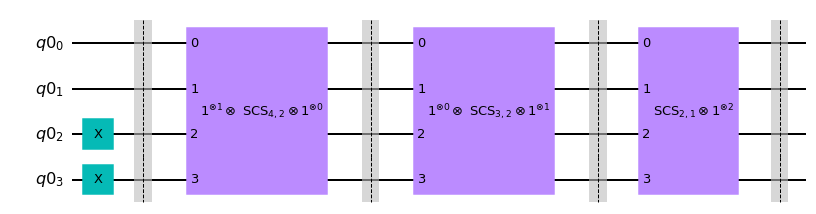

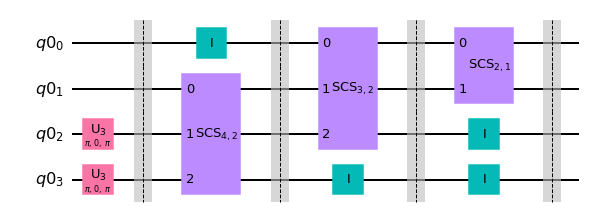

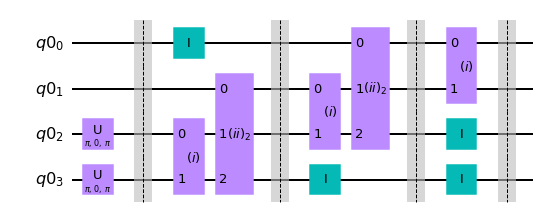

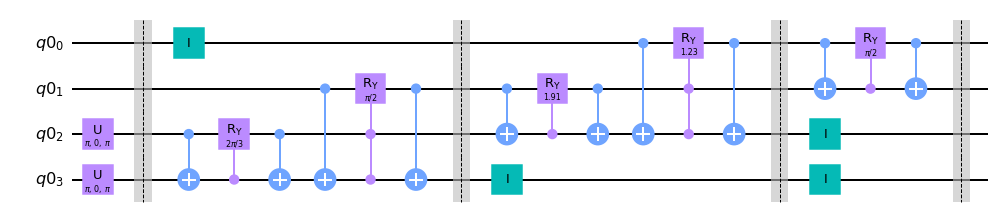


Expected number of elements in superposition: 6


Number of elements in result superposition: 6



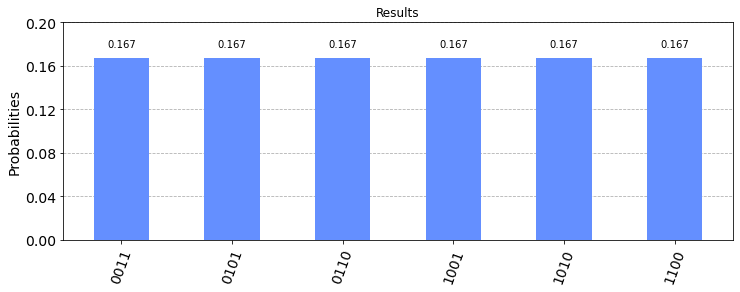

In [12]:
n, k = 4, 2

qc = dicke_state(n, k, barrier=True, draw=True, only_decomposed=False)

print(f"\nExpected number of elements in superposition: {scipy.special.comb(n, k):.0f}\n")

test_circuit_sv(qc)

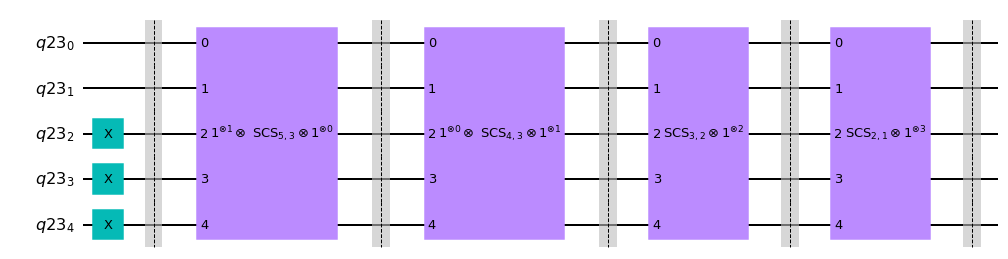

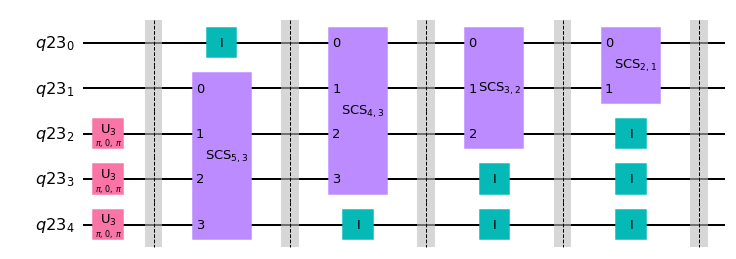

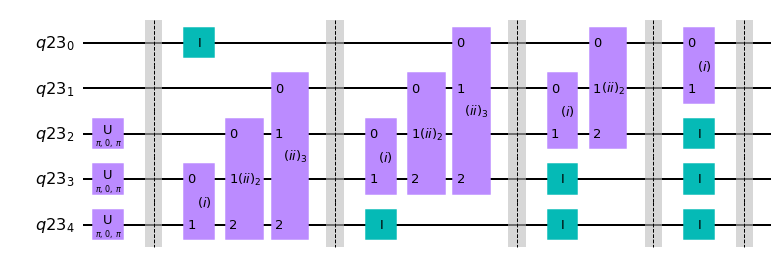

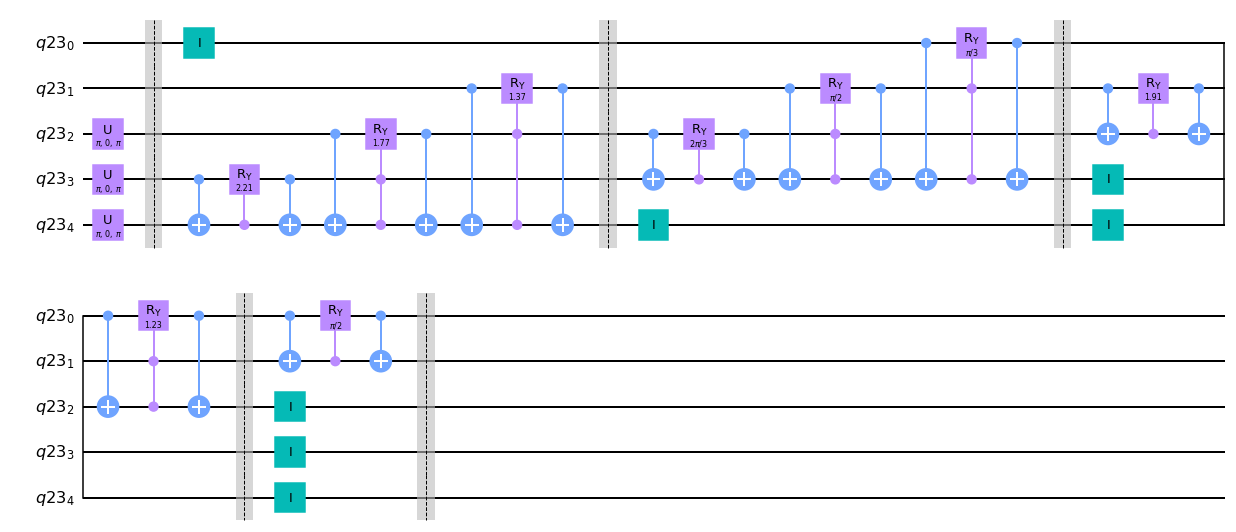


Expected number of elements in superposition: 10


Number of elements in result superposition: 10



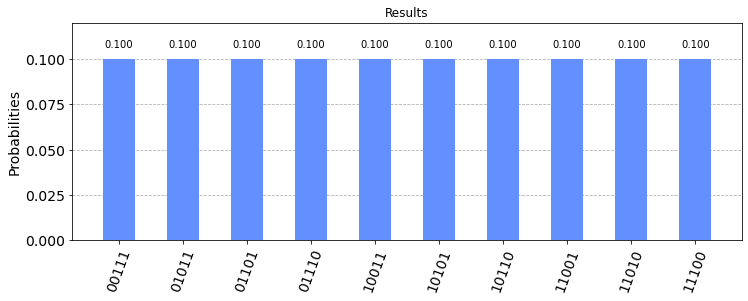

In [13]:
n, k = 5, 3

qc = dicke_state(n, k, barrier=True, draw=True, only_decomposed=False)

print(f"\nExpected number of elements in superposition: {scipy.special.comb(n, k):.0f}\n")

test_circuit_sv(qc)

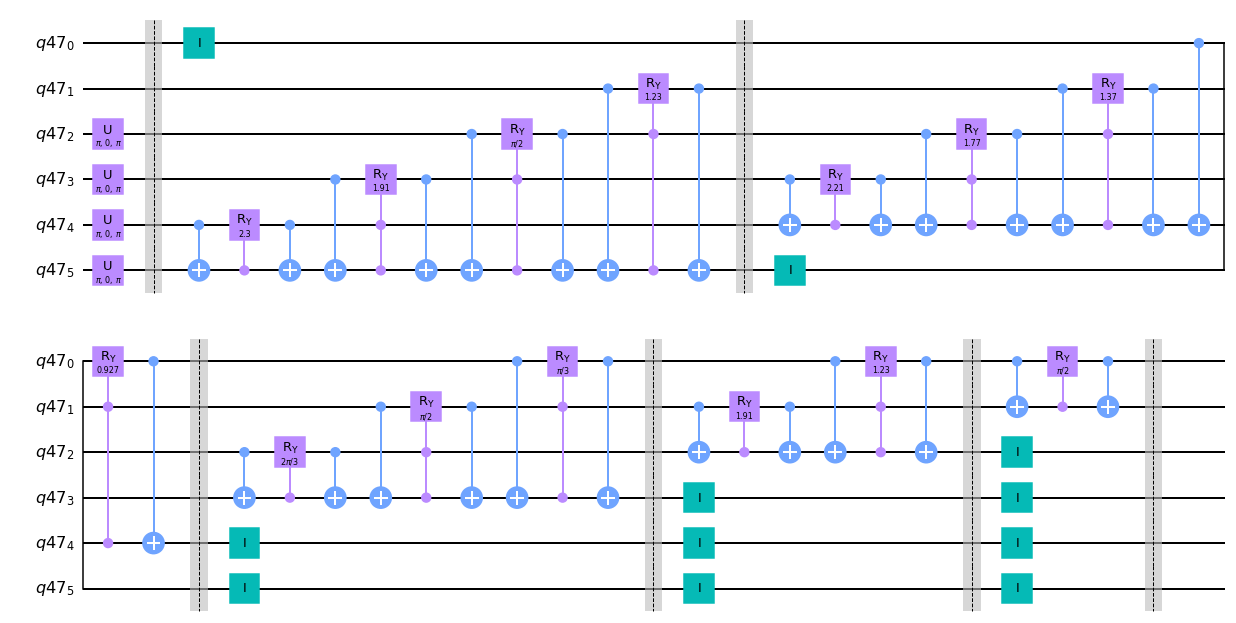


Expected number of elements in superposition: 15


Number of elements in result superposition: 15



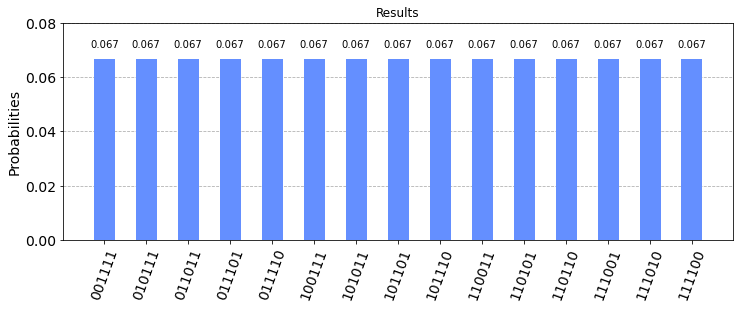

In [14]:
n, k = 6, 4

qc = dicke_state(n, k, barrier=True, draw=True, only_decomposed=True)

print(f"\nExpected number of elements in superposition: {scipy.special.comb(n, k):.0f}\n")

test_circuit_sv(qc)

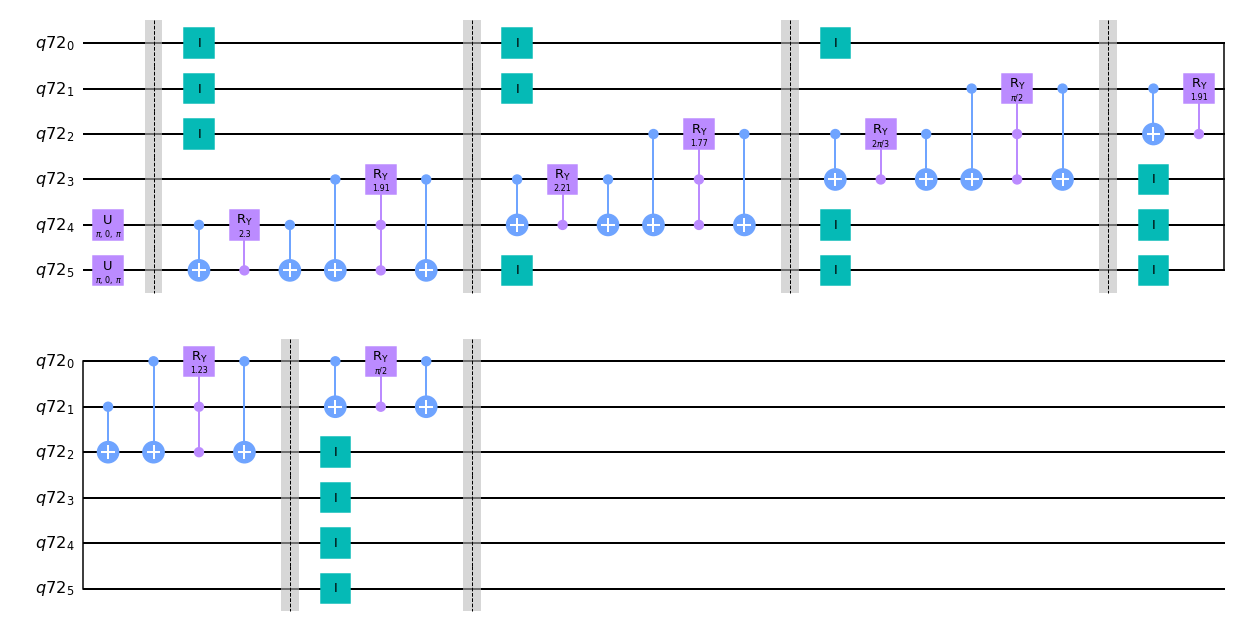


Expected number of elements in superposition: 15


Number of elements in result superposition: 15



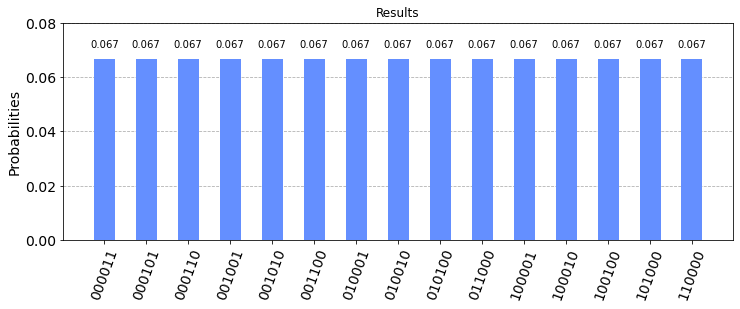

In [15]:
n, k = 6, 2

qc = dicke_state(n, k, barrier=True, draw=True, only_decomposed=True)

print(f"\nExpected number of elements in superposition: {scipy.special.comb(n, k):.0f}\n")

test_circuit_sv(qc)

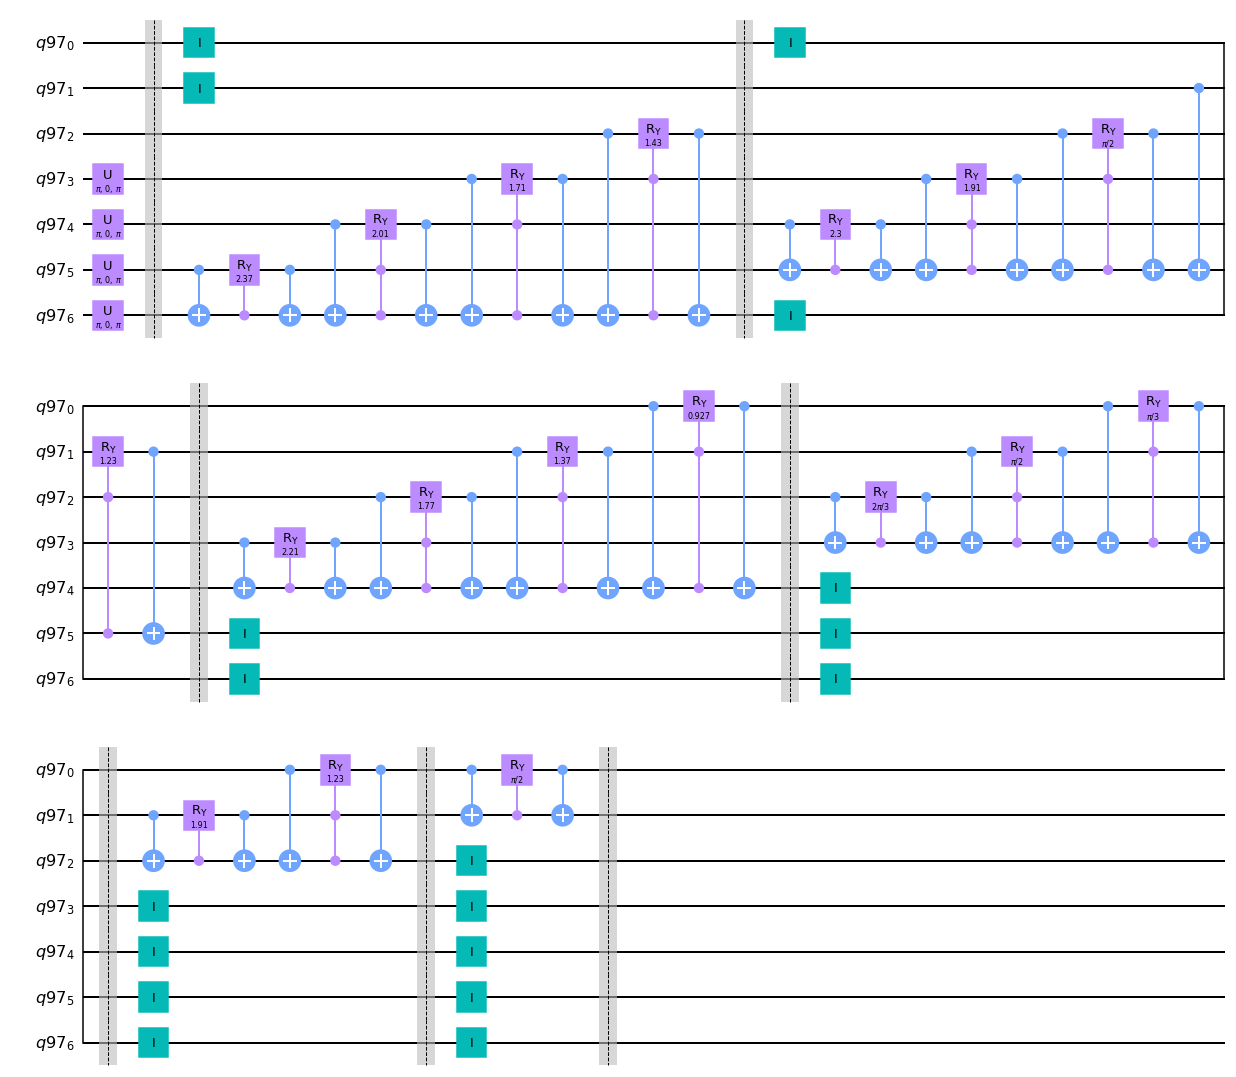


Expected number of elements in superposition: 35


Number of elements in result superposition: 35



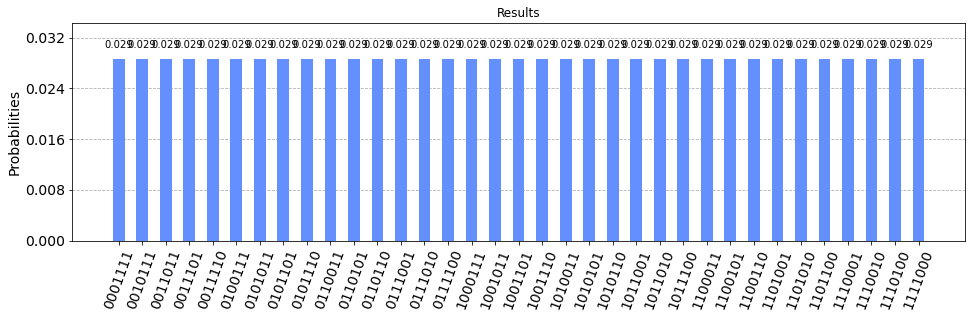

In [16]:
n, k = 7, 4

qc = dicke_state(n, k, barrier=True, draw=True, only_decomposed=True)

print(f"\nExpected number of elements in superposition: {scipy.special.comb(n, k):.0f}\n")

test_circuit_sv(qc, figsize=(16, 4))